In [1]:
import numpy as np               
import matplotlib.pyplot as plt  
import pandas as pd
import statsmodels.api as sm

# 最小二乗法

In [2]:
# データ読込み
UN = np.array(pd.read_csv('data/UN.csv').values[:,1:3]).astype('float64')
UN.shape  # データ行列のサイズ

(207, 2)

In [3]:
UN = UN[~np.isnan(UN).any(axis=1),:]  # nanを含むデータを除く
UN.shape  # nanを除いたデータ行列のサイズ

(193, 2)

In [4]:
logUN = np.log(UN)           # データを対数で変換
# データ
x = logUN[:,1].reshape(-1,1); y = logUN[:,0] 
xc = sm.add_constant(x)      # 定数項に対応する列を加える
lf = sm.OLS(y,xc).fit()      # 最小二乗法
lf.params                    # 推定された定数項と係数

array([ 7.0452008 , -0.49320262])

In [5]:
lf.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.654   
Dependent Variable: y                AIC:                348.5429
Date:               2018-08-20 13:58 BIC:                355.0683
No. Observations:   193              Log-Likelihood:     -172.27 
Df Model:           1                F-statistic:        363.7   
Df Residuals:       191              Prob (F-statistic): 4.32e-46
R-squared:          0.656            Scale:              0.35266 
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const     7.0452     0.1991    35.3790   0.0000    6.6524    7.4380
x1       -0.4932     0.0259   -19.0697   0.0000   -0.5442   -0.4422
-----------------------------------------------------------------
Omnibus:              10.055       Durbin-Watson:          1.864 
Prob(Omnibus):        0.007        Jarque-Bera (JB):       21.166
Skew:                 0.097        Prob(JB):               0.000 
Kurtosis:             4.611        Condition No.:          36    
=================================================================

"""

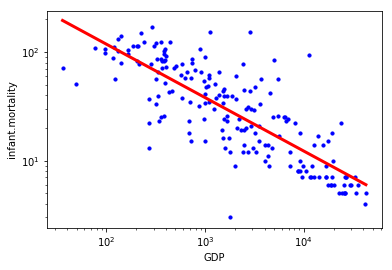

In [6]:
tx = np.linspace(x.min(),x.max(),100).reshape(-1,1) # 予測点の生成
txc = sm.add_constant(tx)                           
py = lf.predict(txc)                                # 予測値
plt.xlabel('GDP'); plt.ylabel('infant.mortality')
plt.xscale("log"); plt.yscale("log")
plt.scatter(UN[:,1],UN[:,0], s=10, c='blue')        # データ点のプロット
plt.plot(np.exp(tx),np.exp(py),'r-',lw=3)           # 予測結果のプロット
plt.show()

# ロバスト回帰

In [7]:
# Davisの体重と身長のデータを読込み
dat = np.array(pd.read_csv('data/Davis.csv').values[:,1:3]).astype('float64')
dat = dat[~np.isnan(dat).any(axis=1),:]  # nanを含むデータを除く
x = dat[:,0].reshape(-1,1)      # 身長[cm]
y = dat[:,-1]                   # 体重[kg]のデータ行列
xc = sm.add_constant(x)         # データ行列に定数項の列を追加
lf = sm.OLS(y, xc).fit()        # 最小二乗法 
lf.params                       # 回帰係数の推定値：(定数項，傾き)

array([1.60093116e+02, 1.50864502e-01])

In [8]:
# 外れ値を除いたデータに最小二乗法を適用
lfr = sm.OLS(np.delete(y,11,0), np.delete(xc,11,0)).fit()
lfr.params                       # 推定された回帰係数

array([136.83660744,   0.51689358])

In [9]:
rf = sm.RLM(y,xc).fit()          # Huber損失によるロバスト推定
rf.params                        # 推定された回帰係数

array([137.81427721,   0.50076743])

In [10]:
rf.scale                         # 推定されたスケール(標準偏差)

5.7176346561692615

In [11]:
rf.summary2()                    # 結果の要約

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Robust linear model
=========================================================
Model:              RLM              Df Residuals: 198   
Dependent Variable: y                Norm:         HuberT
Date:               2018-08-20 13:58 Scale Est.:   mad   
No. Observations:   200              Cov. Type:    H1    
Df Model:           1                Scale:        5.7176
---------------------------------------------------------
        Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
---------------------------------------------------------
const  137.8143   1.7453 78.9642 0.0000 134.3936 141.2350
x1       0.5008   0.0259 19.3678 0.0000   0.4501   0.5514
=========================================================

"""

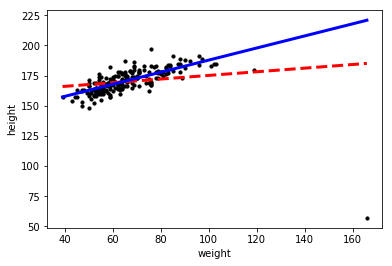

In [12]:
tx = np.linspace(x.min(),x.max(),100).reshape(-1,1)    # 予測点
txc = sm.add_constant(tx)
# プロット
plt.xlabel('weight'); plt.ylabel('height')
plt.scatter(x,y,s=10,c='black')
plt.plot(tx,lf.predict(txc),'r--',lw=3)   # 最小二乗法による予測点
plt.plot(tx,rf.predict(txc),'b-', lw=3)   # ロバスト推定による予測点
plt.show()

In [13]:
# Hampel損失
rfh = sm.RLM(y,xc,M=sm.robust.norms.Hampel()).fit()
rfh.params

array([136.24027068,   0.52543712])

In [14]:
rfh.scale

5.420989982024841

In [15]:
# Turkeyのbiweight損失
rfb = sm.RLM(y,xc,M=sm.robust.norms.TukeyBiweight()).fit() 
rfb.params

array([135.63061588,   0.53426083])

In [16]:
rfb.scale

5.453397062997546

# リッジ回帰

In [17]:
n = 100            # データ数
degree = 8         # 多項式モデルの次数
pardim = degree+1  # 回帰係数の次元
# データ生成
x = np.random.uniform(-2,2,n)
y = np.sin(2*np.pi*x)/x + np.random.normal(scale=0.5,size=n)
mxc = np.power.outer(x,np.arange(pardim))            # データ行列
IE = np.identity(mxc.shape[1]); IE[0,0] = 0          # 行列 I-E_11
# 回帰係数の推定値
np.linalg.solve(np.dot(mxc.T,mxc) + 1*IE, np.dot(mxc.T,y))  

array([ 2.74570081, -0.1998157 , -5.78148742,  0.24368955,  3.24888137,
       -0.07907362, -0.62750468,  0.01199839,  0.03056842])

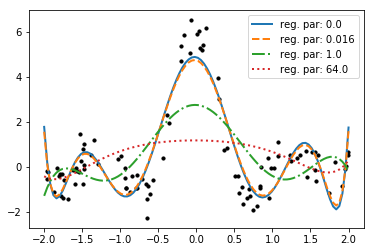

In [18]:
plt.scatter(x,y,c='black',s=10)              # データ点プロット
tx = np.linspace(-2,2,100)                   # テスト点
tpx = np.power.outer(tx,np.arange(pardim))   # テスト点でのデータ行列
a  = np.array([0, 2**(-6), 1, 2**6])         # 正則化パラメータの候補
ls = ['-','--','-.',':']                     # プロットのラインスタイル
for i in np.arange(a.size):
    theta = np.linalg.solve(np.dot(mxc.T,mxc)+a[i]*IE, np.dot(mxc.T,y))
    py = np.dot(tpx,theta)                   # 予測値
    # プロット  
    plt.plot(tx,py,label="reg. par: "+str(round(a[i],3)),ls=ls[i],lw=2) 
plt.legend()
plt.show()

In [19]:
## libraryで計算
n = 100; degree = 8; pardim = degree+1       # データ生成の設定
x = np.random.uniform(-2,2,n)
y = np.sin(2*np.pi*x)/x + np.random.normal(scale=0.5,size=n)
mx = np.power.outer(x,np.arange(pardim))   # データ行列
# 正則化パラメータの設定：定数項は正則化項に含めない．
alpha = 0.01; rp = np.r_[0,np.repeat(alpha/n,degree)] 
ri = sm.OLS(y,mx).fit_regularized(alpha=rp, L1_wt=0) # リッジ回帰
ri.params                                # 推定された回帰係数

array([  4.95628325,  -0.45758673, -20.89959767,   0.34998659,
        22.60699607,  -0.16237187,  -8.76803765,   0.03350073,
         1.10625226])

In [20]:
np.linalg.solve(np.dot(mx.T,mx) + alpha*IE, np.dot(mx.T,y))

array([  4.95628325,  -0.45758673, -20.89959767,   0.34998659,
        22.60699607,  -0.16237187,  -8.76803765,   0.03350073,
         1.10625226])

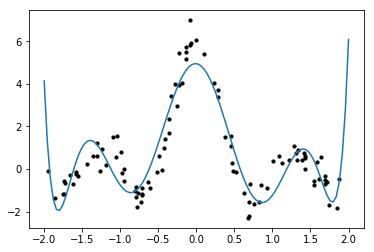

In [21]:
# plot
tx = np.linspace(-2,2,100)                  # 予測点
txc = np.power.outer(tx,np.arange(pardim))  
py = ri.predict(txc)                        # 予測値
plt.scatter(x,y,c='black',s=10)             # データ点プロット
plt.plot(tx,py)
plt.show()

# カーネル回帰分析

In [22]:
# カーネル回帰
from sklearn.kernel_ridge import KernelRidge

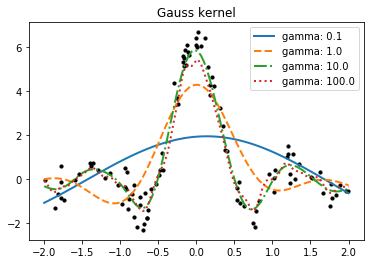

In [23]:
# 計算 & プロット
from sklearn.kernel_ridge import KernelRidge # kernel_ridge モジュール読込み
n = 100                               # データ生成
x = np.random.uniform(-2,2,n); X = x.reshape(-1,1)
y = np.sin(2*np.pi*x)/x + np.random.normal(scale=0.5,size=n)
tx = np.linspace(-2,2,100)                    # テスト点
g = np.array([0.1,1,10,100])                  # gammaの候補
l = ['-','--','-.',':']                       # プロットのラインスタイル
plt.title('Gauss kernel')                   
plt.scatter(x,y,c='black',s=10)               # データ点プロット
for i in np.arange(len(g)):               # カーネル回帰(ガウスカーネル)
    kr = KernelRidge(alpha=1,kernel='rbf',gamma=g[i])
    kr.fit(X, y)                              # データへのあてはめ
    py = kr.predict(tx.reshape(-1,1))         # 予測値の計算
    plt.plot(tx,py,label="gamma: "+str(round(g[i],3)),ls=l[i],lw=2)

plt.legend()
plt.show()